In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_colwidth', None)  # Display full content of each column
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.width', 5000)         # Set display width

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


In [163]:
df=pd.read_csv("Features.csv")

In [164]:
df

,Transaction Date,Value Date,Description,Reference No./Cheque No.,Debit,Credit,Balance,Transaction Type,Transaction Mode,DR/CR Indicator,Transaction ID,Recipient Name,Bank,UPI ID,Note,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,is_weekend,weekofmonth,is_month_start,is_month_end,is_quarter_start,is_quarter_end,hour,minute,second,transaction_amount,is_large_transaction,transaction_count_per_day,transaction_count_per_week,transaction_count_per_month,average_transaction_per_day,cumulative_spent_per_day,time_since_last_transaction,rolling_avg_transaction_7d,rolling_avg_transaction_30d
0,2022-05-31,31 May2022,BY TRANSFER-INBIMPS215110332184/9890160567/XX4470/Son AC-,MAA001032828025MAA001032828025,0.00,100.0,100.00,BY,INB,DR,9890160567,XX4470,NaN,NaN,Son AC-,1,Tuesday,2,5,2022,151,31,22,211,0,5,0,1,0,0,0,0,0,0.00,0,1,18,88,0.00,0.00,0.0,0.000000,0.000000
1,2022-06-02,2 Jun 2022,BY TRANSFER-SBILT02062022133335917538-Transfer to fa-,TRANSFERFROM30640158216,0.00,500.0,600.00,BY,NaN,CR,NaN,NaN,NaN,NaN,NaN,3,Thursday,2,6,2022,153,2,22,282,0,1,0,0,0,0,0,0,0,0.00,0,0,18,107,0.00,0.00,48.0,0.000000,0.000000
2,2022-06-18,18 Jun2022,BY TRANSFER-INBIMPS216918526167/9890160567/XX8237/Son ac-,MAA001051355339MAA001051355339,0.00,1000.0,1600.00,BY,INB,CR,9890160567,XX8237,NaN,NaN,Son ac-,5,Saturday,2,6,2022,169,18,24,298,1,3,0,0,0,0,0,0,0,0.00,0,1,35,107,0.00,0.00,384.0,0.000000,0.000000
3,2022-06-24,24 Jun2022,BY TRANSFER-INBIMPS217515493424/9890160567/XX8237/Son ac-,MAC001014992584MAC001014992584,0.00,1000.0,2600.00,BY,INB,CR,9890160567,XX8237,NaN,NaN,Son ac-,4,Friday,2,6,2022,175,24,25,304,0,4,0,0,0,0,0,0,0,0.00,0,1,22,107,0.00,0.00,144.0,0.000000,0.000000
4,2022-06-25,25 Jun2022,CREDIT INTEREST--,NaN,0.00,2.0,2602.00,TO,NaN,CR,NaN,NaN,NaN,NaN,NaN,5,Saturday,2,6,2022,176,25,25,305,1,4,0,0,0,0,0,0,0,0.00,0,0,22,107,0.00,0.00,24.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,2024-11-04,4 Nov 2024,BY TRANSFER-UPI/CR/430929085524/SAMEER B/ICIC/sawant.123/UPI-,TRANSFERFROM4897733162090,0.00,300.0,1244.81,BY,UPI,CR,430929085524,SAMEER B,ICIC,sawant.123,UPI,0,Monday,4,11,2024,309,4,45,784,0,1,0,0,0,0,0,0,0,0.00,0,2,16,50,147.89,0.00,72.0,103.571429,248.133333
737,2024-11-04,4 Nov 2024,TO TRANSFER-UPI/DR/430902812486/ZOMATO L/UTIB/zomatoorde/UPI-,TRANSFER TO4897691162095,295.78,0.0,949.03,TO,UPI,DR,430902812486,ZOMATO L,UTIB,zomatoorde,UPI,0,Monday,4,11,2024,309,4,45,784,0,1,0,0,0,0,0,0,0,295.78,0,2,16,50,147.89,295.78,0.0,141.682857,251.159333
738,2024-11-05,5 Nov 2024,TO TRANSFER-UPI/DR/467686807162/DILIPKU/YESB/paytmqr5wr/UPI-,TRANSFER TO4897692162094,79.00,0.0,870.03,TO,UPI,DR,467686807162,DILIPKU,YESB,paytmqr5wr,UPI,1,Tuesday,4,11,2024,310,5,45,785,0,1,0,0,0,0,0,0,0,79.00,0,2,16,50,47.00,79.00,24.0,152.968571,251.792667
739,2024-11-05,5 Nov 2024,TO TRANSFER-UPI/DR/431057312820/SHINDE R/COSB/shinderayc/UPI-,TRANSFER TO4897692162094,15.00,0.0,855.03,TO,UPI,DR,431057312820,SHINDE R,COSB,shinderayc,UPI,1,Tuesday,4,11,2024,310,5,45,785,0,1,0,0,0,0,0,0,0,15.00,0,2,16,50,47.00,94.00,0.0,155.111429,250.292667


In [165]:
df.columns

Index(['Transaction Date', 'Value Date', 'Description', 'Reference No./Cheque No.', 'Debit', 'Credit', 'Balance', 'Transaction Type', 'Transaction Mode', 'DR/CR Indicator', 'Transaction ID', 'Recipient Name', 'Bank', 'UPI ID', 'Note', 'dayofweek', 'weekday', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'date_offset', 'is_weekend', 'weekofmonth', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'hour', 'minute', 'second', 'transaction_amount', 'is_large_transaction', 'transaction_count_per_day', 'transaction_count_per_week', 'transaction_count_per_month', 'average_transaction_per_day', 'cumulative_spent_per_day', 'time_since_last_transaction', 'rolling_avg_transaction_7d', 'rolling_avg_transaction_30d'], dtype='object')

Weekend Spending: 380433.88999999996
Weekday Spending: 819965.24


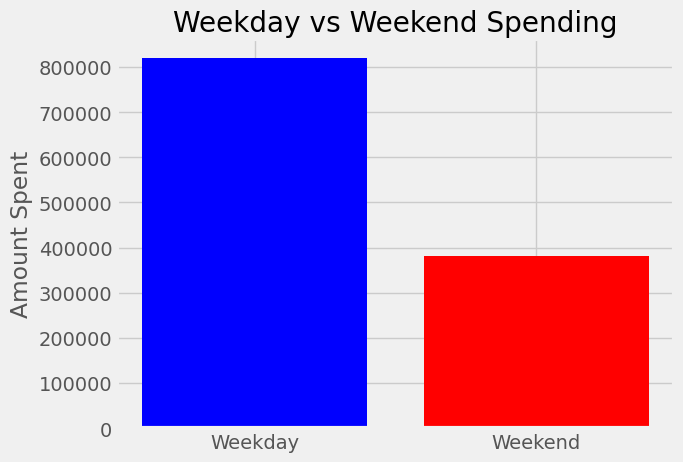

In [166]:
weekend_spending = df[df["is_weekend"] == 1]["Balance"].sum()
weekday_spending = df[df["is_weekend"] == 0]["Balance"].sum()

print(f"Weekend Spending: {abs(weekend_spending)}")
print(f"Weekday Spending: {abs(weekday_spending)}")

plt.bar(["Weekday", "Weekend"], [abs(weekday_spending), abs(weekend_spending)], color=["blue", "red"])
plt.title("Weekday vs Weekend Spending")
plt.ylabel("Amount Spent")
plt.show()


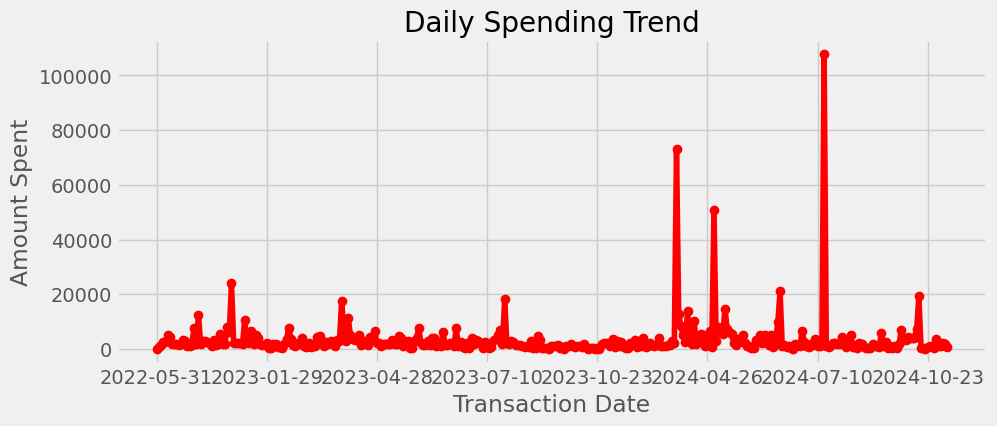

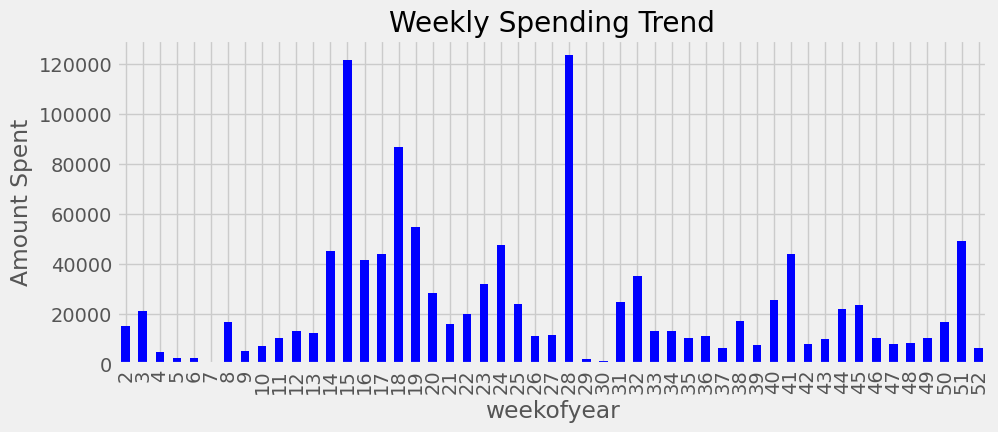

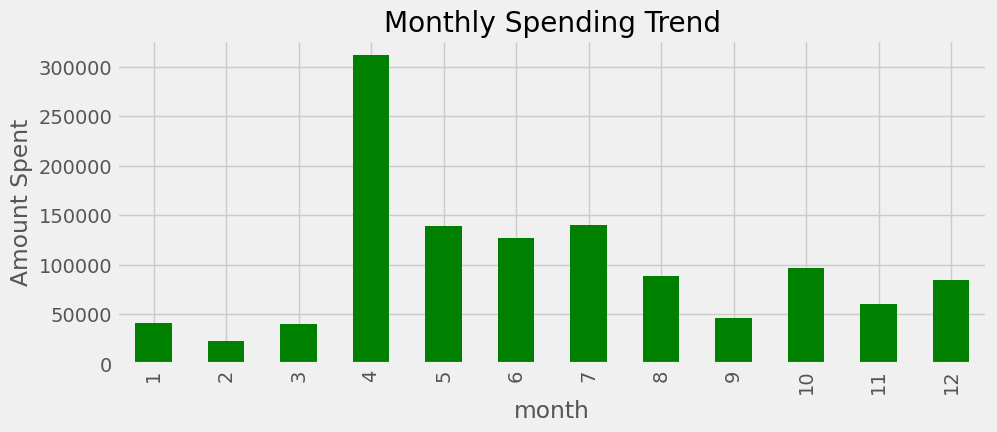

In [167]:
# Daily Spending
daily_spending = df.groupby("Transaction Date")["Balance"].sum()
plt.figure(figsize=(10, 4))
daily_spending.plot(kind="line", marker="o", color="red")
plt.title("Daily Spending Trend")
plt.ylabel("Amount Spent")
plt.show()

# Weekly Spending
weekly_spending = df.groupby("weekofyear")["Balance"].sum()
plt.figure(figsize=(10, 4))
weekly_spending.plot(kind="bar", color="blue")
plt.title("Weekly Spending Trend")
plt.ylabel("Amount Spent")
plt.show()

# Monthly Spending
monthly_spending = df.groupby("month")["Balance"].sum()
plt.figure(figsize=(10, 4))
monthly_spending.plot(kind="bar", color="green")
plt.title("Monthly Spending Trend")
plt.ylabel("Amount Spent")
plt.show()


In [168]:
avg_transaction_size = df["Balance"].abs().mean()
print(f"Average Transaction Size: {avg_transaction_size}")


Average Transaction Size: 1619.9718353576247


In [169]:
high_spending_month = monthly_spending.idxmax()
low_spending_month = monthly_spending.idxmin()

print(f"Highest Spending Month: {high_spending_month}")
print(f"Lowest Spending Month: {low_spending_month}")


Highest Spending Month: 4
Lowest Spending Month: 2


In [170]:
# Count transactions per UPI ID
transaction_counts = df['UPI ID'].value_counts().reset_index()
transaction_counts.columns = ['UPI ID', 'Transaction Frequency']
# transaction_counts
# Merge with original data
# df = df.merge(transaction_counts, on='UPI ID')

In [171]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

# Aggregate transaction counts per UPI ID on a weekly basis
df['week'] = df['Transaction Date'].dt.isocalendar().week
weekly_counts = df.groupby(['UPI ID', 'week'])['transaction_amount'].sum().reset_index()

weekly_counts


,UPI ID,week,transaction_amount
0,0791363A00,35,30.00
1,7045314562,8,0.00
2,7264817938,23,0.00
3,7448295363,49,1.00
4,7770074874,46,0.00
...,...,...,...
502,vinayracha,38,116.00
503,vyapar.170,24,210.00
504,write2adit,17,71.00
505,zomatoorde,44,576.00


In [172]:
# from sklearn.cluster import KMeans
# import numpy as np

# # Prepare clustering data
# X = df[['transaction_amount', 'Transaction Frequency']].values

# # Apply K-Means clustering
# kmeans = KMeans(n_clusters=3, random_state=42)
# df['Cluster'] = kmeans.fit_predict(X)

# df[['UPI ID', 'transaction_amount', 'Transaction Frequency', 'Cluster']]


In [173]:
def categorize_transaction(amount):
    if amount < 100:
        return 'Small Vendor'
    elif amount <500:
        return 'Medium Vendor'
    else:
        return 'Large Vendor'

df['Category'] = df['Balance'].apply(categorize_transaction)
df[['UPI ID', 'Balance', 'Category']]


,UPI ID,Balance,Category
0,NaN,100.00,Medium Vendor
1,NaN,600.00,Large Vendor
2,NaN,1600.00,Large Vendor
3,NaN,2600.00,Large Vendor
4,NaN,2602.00,Large Vendor
...,...,...,...
736,sawant.123,1244.81,Large Vendor
737,zomatoorde,949.03,Large Vendor
738,paytmqr5wr,870.03,Large Vendor
739,shinderayc,855.03,Large Vendor


In [174]:
def total_transactions():
    grouped = df.groupby(["Recipient Name"]).agg(
        transaction_count=("Transaction ID", "count")
    ).reset_index()
    
    table = PrettyTable(["Recipient Name", "Total Transactions"])
    for _, row in grouped.iterrows():
        table.add_row([row["Recipient Name"], row["transaction_count"]])
    
    print("Total Transactions Summary")
    print(table)

# total_transactions()


In [175]:
def print_selected_columns(df, columns):
    for index, row in df.iterrows():
        print(f"Row {index}:")
        for col in columns:
            if col in df.columns:
                print(f"  {col}: {row[col]}")
            else:
                print(f"  {col}: Column not found!")
        print("-" * 50)  # Separator for better readability

# Example usage:
selected_columns = ["Recipient Name","UPI ID", "Note"]  # Replace with actual column names
print_selected_columns(df, selected_columns)


Row 0:
  Recipient Name: XX4470
  UPI ID: nan
  Note: Son AC-
--------------------------------------------------
Row 1:
  Recipient Name: nan
  UPI ID: nan
  Note: nan
--------------------------------------------------
Row 2:
  Recipient Name: XX8237
  UPI ID: nan
  Note: Son ac-
--------------------------------------------------
Row 3:
  Recipient Name: XX8237
  UPI ID: nan
  Note: Son ac-
--------------------------------------------------
Row 4:
  Recipient Name: nan
  UPI ID: nan
  Note: nan
--------------------------------------------------
Row 5:
  Recipient Name: PRACHI S
  UPI ID: prachiswt2
  Note: Pay t
--------------------------------------------------
Row 6:
  Recipient Name: PRACHI S
  UPI ID: prachiswt2
  Note: Trans
--------------------------------------------------
Row 7:
  Recipient Name: PRACHI S
  UPI ID: prachiswt2
  Note: UPI
--------------------------------------------------
Row 8:
  Recipient Name: PRACHI S
  UPI ID: rutuswt052
  Note: UPI
------------------------

In [176]:
def print_transaction_details(df):
    """
    Prints every row with all the extracted details from the DataFrame.
    """
    for index, row in df.iterrows():
        print(f"Row {index}:")
        for col in df.columns:
            print(f"  {col}: {row[col]}")
        print("-" * 50)  # Separator for better readability
print_transaction_details(df)
# print_transaction_details(df)
        


Row 0:
  Transaction Date: 2022-05-31 00:00:00
  Value Date: 31 May2022
  Description: BY TRANSFER-INBIMPS215110332184/9890160567/XX4470/Son AC-
  Reference No./Cheque No.: MAA001032828025MAA001032828025
  Debit: 0.0
  Credit: 100.0
  Balance: 100.0
  Transaction Type: BY
  Transaction Mode: INB
  DR/CR Indicator: DR
  Transaction ID: 9890160567
  Recipient Name: XX4470
  Bank: nan
  UPI ID: nan
  Note: Son AC-
  dayofweek: 1
  weekday: Tuesday
  quarter: 2
  month: 5
  year: 2022
  dayofyear: 151
  dayofmonth: 31
  weekofyear: 22
  date_offset: 211
  is_weekend: 0
  weekofmonth: 5
  is_month_start: 0
  is_month_end: 1
  is_quarter_start: 0
  is_quarter_end: 0
  hour: 0
  minute: 0
  second: 0
  transaction_amount: 0.0
  is_large_transaction: 0
  transaction_count_per_day: 1
  transaction_count_per_week: 18
  transaction_count_per_month: 88
  average_transaction_per_day: 0.0
  cumulative_spent_per_day: 0.0
  time_since_last_transaction: 0.0
  rolling_avg_transaction_7d: 0.0
  rolling_a

  is_weekend: 1
  weekofmonth: 3
  is_month_start: 0
  is_month_end: 0
  is_quarter_start: 0
  is_quarter_end: 0
  hour: 0
  minute: 0
  second: 0
  transaction_amount: 1287.0
  is_large_transaction: 1
  transaction_count_per_day: 3
  transaction_count_per_week: 28
  transaction_count_per_month: 117
  average_transaction_per_day: 685.6666666666666
  cumulative_spent_per_day: 2057.0
  time_since_last_transaction: 0.0
  rolling_avg_transaction_7d: 325.85714285714283
  rolling_avg_transaction_30d: 200.763
  week: 15
  Category: Large Vendor
--------------------------------------------------
Row 167:
  Transaction Date: 2023-04-15 00:00:00
  Value Date: 15 Apr2023
  Description: BY TRANSFER-UPI/CR/310534391690/JitenIs/IDFB/9860566455/Payme-
  Reference No./Cheque No.: TRANSFERFROM4897737162096
  Debit: 0.0
  Credit: 20.0
  Balance: 1309.82
  Transaction Type: BY
  Transaction Mode: UPI
  DR/CR Indicator: CR
  Transaction ID: 310534391690
  Recipient Name: JitenIs
  Bank: IDFB
  UPI ID: 986

  quarter: 4
  month: 11
  year: 2023
  dayofyear: 311
  dayofmonth: 7
  weekofyear: 45
  date_offset: 787
  is_weekend: 0
  weekofmonth: 1
  is_month_start: 0
  is_month_end: 0
  is_quarter_start: 0
  is_quarter_end: 0
  hour: 0
  minute: 0
  second: 0
  transaction_amount: 24.0
  is_large_transaction: 0
  transaction_count_per_day: 3
  transaction_count_per_week: 16
  transaction_count_per_month: 50
  average_transaction_per_day: 96.33333333333331
  cumulative_spent_per_day: 289.0
  time_since_last_transaction: 0.0
  rolling_avg_transaction_7d: 85.71428571428571
  rolling_avg_transaction_30d: 76.76666666666667
  week: 45
  Category: Large Vendor
--------------------------------------------------
Row 403:
  Transaction Date: 2023-11-12 00:00:00
  Value Date: 12 Nov2023
  Description: TO TRANSFER-UPI/DR/331614187502/BHARTI A/AIRP/airtelprep/Payme-
  Reference No./Cheque No.: TRANSFER TO4897696162090
  Debit: 265.0
  Credit: 0.0
  Balance: 1008.92
  Transaction Type: TO
  Transaction Mo

  Value Date: 28 Sep2024
  Description: TO TRANSFER-UPI/DR/427297320117/DILIPKU/YESB/paytmqr5cb/food-
  Reference No./Cheque No.: TRANSFER TO4897696162090
  Debit: 178.0
  Credit: 0.0
  Balance: 336.81
  Transaction Type: TO
  Transaction Mode: UPI
  DR/CR Indicator: DR
  Transaction ID: 427297320117
  Recipient Name: DILIPKU
  Bank: YESB
  UPI ID: paytmqr5cb
  Note: food
  dayofweek: 5
  weekday: Saturday
  quarter: 3
  month: 9
  year: 2024
  dayofyear: 272
  dayofmonth: 28
  weekofyear: 39
  date_offset: 608
  is_weekend: 1
  weekofmonth: 4
  is_month_start: 0
  is_month_end: 0
  is_quarter_start: 0
  is_quarter_end: 0
  hour: 0
  minute: 0
  second: 0
  transaction_amount: 178.0
  is_large_transaction: 0
  transaction_count_per_day: 3
  transaction_count_per_week: 12
  transaction_count_per_month: 52
  average_transaction_per_day: 106.0
  cumulative_spent_per_day: 178.0
  time_since_last_transaction: 0.0
  rolling_avg_transaction_7d: 78.85714285714286
  rolling_avg_transaction_30d:

In [177]:
import holidays
import pandas as pd

indian_holidays = holidays.India(years=2024)

df = pd.DataFrame(indian_holidays.items(), columns=["Date", "Holiday"])
df["Date"] = pd.to_datetime(df["Date"])

# df
